# Вейвлет-преобразование 

Обычно для построения оценок спектра мощности временных рядов используют преобразование Фурье. Оно обладает способностью фокусировать в точку «размазанную» по времени информацию о периодичности функции при переходе из временной области в частотную. Достигается это за счет того, что ядро преобразования Фурье не локализовано во времени, но имеет предельную локализацию в частотной области. Это обстоятельство и делает преобразование Фурье хорошим инструментом для изучения процессов, характеристики которых не меняются со временем. 
Напротив, вейвлет-анализ основан на использовании локализованных во времени ядер преобразования, размеры которых согласованы с масштабом изучаемых компонентов ряда. 

## Непрерывное вейвлет-преобразование

Основная идея вейвлет-преобразования отвечает специфике многих временных рядов, демонстрирующих эволюцию во времени своих основных характеристик – среднего значения, дисперсии, периодов, амплитуд и фаз гармонических компонентов.
Предположим, что имеется некоторый временной ряд $x_n$, заданный с равным шагом по времени $\delta t$, где  $n=0 \dots N-1$. 

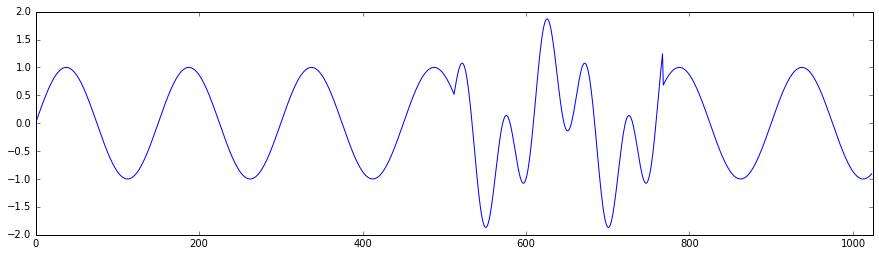

In [1]:
import numpy as np
import pylab as pl
%matplotlib inline
pl.rcParams["figure.figsize"] = (15,4)
# тестовый временной ряд
Ns=1024
Nlo=0 
Nhi=Ns
dt =1.
# cинусоиды с периодами 50 и 150
t=np.arange(0.0,dt*Ns,dt)
A=np.sin(2.0*np.pi*t/150.)
B=np.sin(2.0*np.pi*t/50.)
A[512:768]+=B[0:256]
x=A[:]
pl.plot(t,x)
_=pl.xlim([0, Ns])

Можно задать некоторую "волновую" вейвлет-функция $\psi_0(\eta )$, хорошо локализованную во временном и частотном пространстве, зависящая от безразмерного параметра времени $\eta$. Например это может быть вейвлет Морле, показанный на рисунке ниже,и представляющий собой   косинусоиду и синусоиду, модулированную Гауссианной:
$$
\psi_0(\eta)=\pi^{-1/4}e^{i\omega_0 \eta} e^{-\eta^2/2}, \tag{1}
$$
где  $\omega_0$ это безразмерная частота вейвлета, часто используется значение $\omega_0=6$.


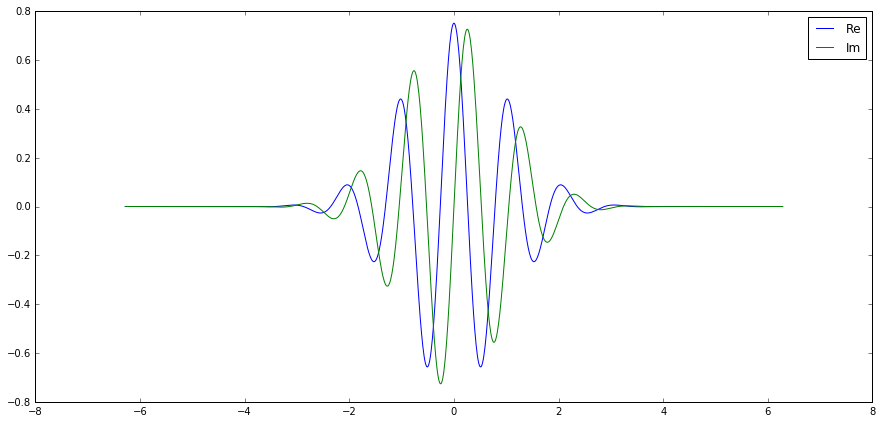

In [2]:
pl.rcParams["figure.figsize"] = (15,7)
def morlet(x, w0=6.0):
    return np.pi**-0.25 * np.exp(1j*w0*x)*np.exp(-0.5*x**2)

m_x = np.linspace(-2 * np.pi, 2 * np.pi, 1024)
m = morlet(m_x)
pl.plot(m_x,np.real(m), label="Re")
pl.plot(m_x,np.imag(m), label="Im")
_ = pl.legend()


Тогда непрерывное вейвлет-преобразование определяется как свертка временного ряда $x_n$ c масштабированным и смещенным вейвлетом $\psi(\eta)$:
$$
W_n(s)=\sum_{n'=0}^{N-1}x_{n'}\psi* \left[{ \frac{(n'-n)\delta t}{s}}\right], \tag{2}
$$
где звездочкой обозначена процедура комплекного сопряжения. 

*Если комплексное число $z = x + iy$, то число $\bar z=x-iy$ называется сопряжённым (или комплексно сопряжённым) к $z$.*

Для нормализации параметров масштабов вейвлета используется параметр длины волны Фурье вейвлета. Для вейвлета Морле:
$$
\lambda = \frac{4 \pi}  {\omega_0 +\sqrt{2+\omega_0^2}} \tag{3}.
$$

In [3]:
#функция комплексного сопряжения
def conj(a):
    return np.real(a)-1j*np.imag(a)

#параметры смещений
n=np.arange(Nlo , Nhi)
#параметры масштабов
s=np.array([1, 50, 100, 150, 200])
w0=6. #частота вейвлета
fwl=4* np.pi/(w0 + np.sqrt(2.0+w0**2)) # длина волны вейвлета, формула (3)
sf=s/fwl #нормализация масштабов
#вычисление по формуле (2)
W=np.zeros([len(s), len(n)],dtype=np.complex64)
for i in range(len(s)):
    for j in range(len(n)):
        for n_ in range (Ns):
            W[i,j]= W[i,j]+x[n_]*conj(morlet((n_-n[j])*dt/sf[i],w0=w0))

Если визуализировать результат вейвлет преобразования в виде двухмерной карты, то получается т.н. скалограмма, показывающая как изменятся со временем частота анализируемого временного ряда. 

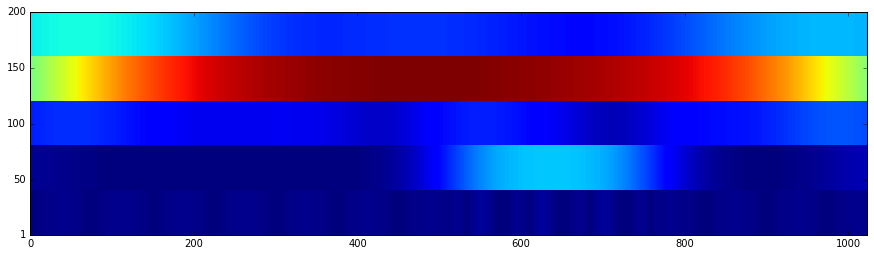

In [4]:
pl.rcParams["figure.figsize"] = (15,4)
im=pl.imshow(np.abs(W),
             cmap=pl.cm.jet,
             extent=[n[0],n[-1],s[-1],s[0]],
             aspect='auto',
             interpolation="nearest")
pl.ylim(s[0],s[-1])
_=pl.yticks(s)

## Вейвлет-преобразование с использованием БПФ

Согласно теореме о свертке вейвлет-преобразование равно:
$$
W_n(s)=\sum_{k=0}^{N-1}\hat x_k \hat \psi *(s \omega_k)e^{i w_k n \delta t} \tag{4}
$$
где угловая частота $\omega_k$ определяется как:
$$
\omega_k = 
 \begin{cases}
   2 \pi k  \over {N \delta t} & {k \leq N/2}\\
   -2 \pi k  \over N \delta t & {k > N/2} \tag{5}
 \end{cases}
$$
$\hat x_k$ - дискретное преобразование Фурье исходного временного ряда $x_k$, $\hat \psi (s \omega)$ - непрерывное Фурье преобразование вейвлета $\psi(\eta)$.
В частности для вейвлета Морле:
$$
\hat \psi_0 (s \omega) = \pi^{-1/4} H(\omega)e^{-{(s\omega - \omega_0)}^2 /2},
$$
где $H(\omega)$ - функция Хэвисайда, $H(\omega) = 1$ если $\omega >0, H(\omega)=0$ в других случаях.


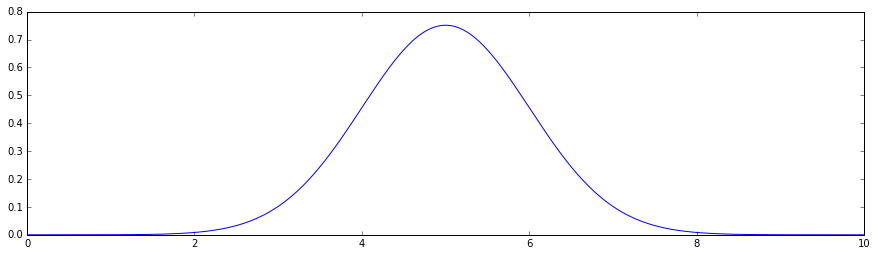

In [5]:
def hat_morlet(s_omega, w0=5.):
    H= np.ones(len(s_omega))
    n=len(s_omega)
    H[s_omega < 0.0] = 0.0 #функция Хэвисайда
    xhat=0.75112554*( np.exp(-(s_omega-w0)**2/2.0))*H
    return xhat

s_omega = np.linspace(0, 10, 1024)
m = hat_morlet(s_omega)
_ = pl.plot(s_omega, m)

Используя формулу (4) и реализованную ранее процедуру быстрого преобразования Фурье, можно вычислять вейвлет-преобразование для заданных масштабов и одновременно для всех смещений.

In [6]:
# Функции, вычисляющие БПФ
def _W(k,N, n=1, inv=False):
    w=-2*np.pi*1j*k*n/N
    if not inv: return np.exp(w)
    else: return np.exp(-w)

def fft(x, inv=False):
    N=len(x)
    if N % 2 > 0:
        raise ValueError("Количество отсчетов должно быть степенью 2-ки")
    Y1=[]
    Y2=[]
    if N == 2: #условие окончания рекурсии
        return [x[0]+x[1], x[0]-x[1]]
    else:
        x1=x[::2]  #четные
        x2=x[1::2] #нечетные
        X1 = fft(x1, inv=inv)
        X2 = fft(x2, inv=inv)     
    for k in range(N/2):
        tmp=_W(k,N, inv=inv)*X2[k]
        Y1.append(X1[k]+ tmp)
        Y2.append(X1[k]- tmp)
    return Y1+Y2 #объединение двух списков

s=np.arange(1,250, step=1) #масштабы вейвлета
hat_x =fft(x)
omega_ = [2* np.pi * k/ Ns/dt for k in range(0, Ns/2)] #формула (5)
_omega = [-2* np.pi * k/ Ns/dt for k in range(Ns/2, Ns)]
omega = np.array(omega_+_omega)
w0=5.
fwl=4* np.pi/(w0 + np.sqrt(2.0+w0**2))
sf=s/fwl
# Реализация формулы (4), но с учетом того, что затем будет применено обратное БПФ
Ws=np.zeros([len(s), Ns],dtype=np.complex64)
for scaleindex in range(len(s)):
    currentscale=sf[scaleindex]
    s_omega = omega*currentscale
    psihat=hat_morlet(s_omega,w0)
    convhat = psihat * hat_x
    W = np.array(fft(convhat, inv=True))
    Ws[scaleindex,:]=W[:]/Ns


Используя БПФ можно, например, построить скалограмму для 250 различный значений масштабов. Так же это позволяет анализировать достаточно большие временные ряды.

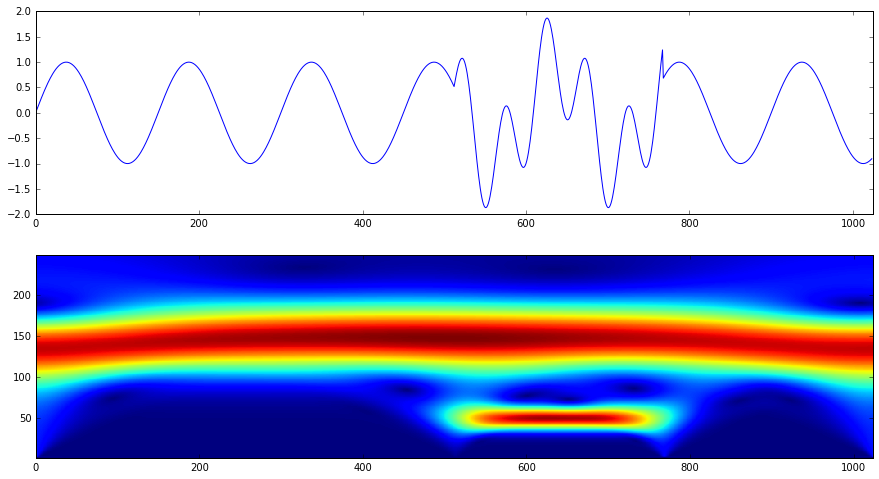

In [7]:
pl.rcParams["figure.figsize"] = (15,8)
pl.subplot(2,1,1)
pl.plot(t,x)
_=pl.xlim([0, Ns])
pl.subplot(2,1,2)
im=pl.imshow(np.abs(Ws),
             cmap=pl.cm.jet,
             extent=[n[0],n[-1],s[-1],s[0]],
             aspect='auto',
             interpolation="nearest")
_=pl.ylim(s[0],s[-1])

Для сравнения, ниже показаны периодограммы тестового временного ряда полученные в результате обычного БПФ.

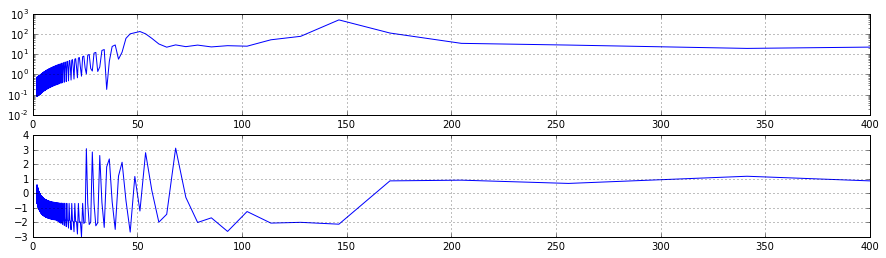

In [8]:
pl.rcParams["figure.figsize"] = (15,4)
X=fft(x)
A=np.abs(X)
P=np.angle(X)
N=len(A)
nu=np.arange(N)/dt/N
np.seterr(divide='ignore')
T=1/nu
pl.subplot(2,1,1)
pl.semilogy(T[0:N//2], A[0:N//2])
pl.xlim([0, 400])
pl.grid()
pl.subplot(2,1,2)
pl.plot(T[0:N//2], P[0:N//2])
pl.xlim([0, 400])
pl.grid()

Таким образом, используя вейвлет-преобразование можно не только уставить наличие тех или иных частот в исследуемом временном ряду, но и проследить за их эволюцией во времени.

## Дополнительные задания

1. Выясните как влияет значение параметра $\omega_0$ на результат вейвлет-преобразования.
2. Выполните фурье и вейвлет-анализ среднегодового количества солнечных пятен. Выясните изменяется ли со временем период колебаний количества солнечных пятен?

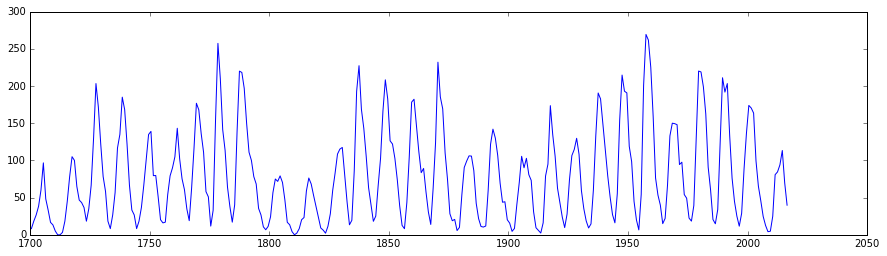

In [9]:
pl.rcParams["figure.figsize"] = (15,4)
url = 'http://www.sidc.be/silso/DATA/SN_y_tot_V2.0.txt'
data = np.genfromtxt(url)
y=data[:,0]
N=data[:,1]
_=pl.plot(y,N)

*Литература*
1. Compo, Gilbert P. A Practical Guide to Wavelet Analysis // Amer. Meteor. Soc. In Bulletin of the American Meteorological Society. - 1998, - vol. 79, no. 1. – P 61-78
2. Верзунов, С.Н. Вейвлет-преобразование как инструмент анализа магнитовариационных данных // Проблемы автоматики и управления – Бишкек: Илим, 2014 - №2 – C. 52-61.
3. Витязев, В.В. Вейвлет-анализ временных рядов: Учеб.пособие. – СПб.:Изд-во С.-Петерб. ун-та, 2001. - 65 с.